# Collect generated text for evaluation data
We need to collect text generated by the model for the following two evaluation tasks:

1. Is reader-aware text (1) more relevant and (2) more likely to elicit interesting information from the author, than non-aware text?
2. Is it just as easy to differentiate different reader groups in the generated text as it is for the real text?

In [1]:
import torch
val_data = torch.load('../../data/reddit_data/combined_data_test_data.pt', map_location='cpu')
# convert to data frame because easier
import pandas as pd
val_data = pd.DataFrame(list(val_data))
data_cols = ['article_id', 'author_has_subreddit_embed', 'author_has_text_embed', 'reader_token_str', 'source_text', 'target_text', 'subreddit_embed', 'text_embed']
val_data = val_data.loc[:, data_cols]
print(val_data.shape)
# get metadata
import pandas as pd
post_metadata = pd.read_csv('../../data/reddit_data/combined_data_question_data.gz', sep='\t', compression='gzip', usecols=['article_id', 'subreddit'])
# add subreddit info
val_data = pd.merge(val_data, post_metadata, on=['article_id'], how='left')

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)


(51302, 8)


## Collect data for no-reader and reader-aware generated questions
After generating text with `test_question_generation.py`, we can filter for questions generated by no-reader and reader-aware models (additional condition: question should have some reader information attached).

In [13]:
import gzip
no_reader_pred_text = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_output_text.gz', 'rt')))
reader_aware_pred_text = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/test_data_output_text.gz', 'rt')))

In [17]:
import torch
test_data = torch.load('../../data/reddit_data/combined_data_val_data.pt')
# convert to dataframe
test_data = test_data.data.to_pandas()
test_data = test_data.loc[:, ['article_id', 'reader_token_str', 'source_text']]
# add predicted text
test_data = test_data.assign(**{
    'text_only_model_pred_text' : no_reader_pred_text,
    'reader_model_pred_text' : reader_aware_pred_text,
})
## add subreddit data
import pandas as pd
submission_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip', usecols=['id', 'subreddit'])
submission_data.rename(columns={'id' : 'article_id'}, inplace=True)
test_data = pd.merge(test_data, submission_data, on='article_id', how='left')
## limit to data where output is different!!
output_diff_test_data = test_data[test_data.loc[:, 'text_only_model_pred_text']!=test_data.loc[:, 'reader_model_pred_text']]
print(f'{output_diff_test_data.shape[0]}/{test_data.shape[0]} output that are different across models')
display(output_diff_test_data.head())

25495/51302 output that are different across models


,article_id,reader_token_str,source_text,text_only_model_pred_text,reader_model_pred_text,subreddit
22989,bc5yeu,<NONUS_AUTHOR>,"My sister is 34 and I'm 40, but since our earl...",Why did you even make this post?,Why would you do that to someone you're overre...,AmItheAsshole
22991,cbjgh5,<RESPONSE_TIME_1_AUTHOR>,Is it considered retaliation on my landlords p...,Do you have a lease or are you month to month?,Whose name is on the lease?,legaladvice
22992,a9wlwo,<EXPERT_PCT_0_AUTHOR>,"Like, I’m talking, age 30, at least 20 yrs of ...",Do you have an adult in your life that you tru...,Do you have an adult in your life that you tru...,Advice
22994,98f4o1,<US_AUTHOR>,I’m hoping someone can give me advice on how t...,What is their income?,Do they have home insurance?,personalfinance
22995,98f4o1,<EXPERT_PCT_0_AUTHOR>,I’m hoping someone can give me advice on how t...,What is their income?,Do they have home insurance?,personalfinance


In [50]:
## get sample from different subreddits
import numpy as np
np.random.seed(123)
sample_output_data = []
samples_per_reader_group = 5
for subreddit_i, data_i in output_diff_test_data.groupby('subreddit'):
    # remove UNK readers
    data_i = data_i[data_i.loc[:, 'reader_token_str']!='UNK']
    for reader_token_j, data_j in data_i.groupby('reader_token_str'):
        article_ids_j = np.random.choice(data_j.loc[:, 'article_id'].unique(), samples_per_reader_group, replace=False)
        sample_data_j = data_j[data_j.loc[:, 'article_id'].isin(article_ids_j)].drop_duplicates('article_id')
        sample_output_data.append(sample_data_j)
sample_output_data = pd.concat(sample_output_data, axis=0)
print(f'{sample_output_data.shape[0]} sample data')
display(sample_output_data.head())
# ## save to file
# sample_output_data.to_csv('../../data/reddit_data/annotation_data/text_quality_ground_truth_data.tsv', sep='\t', index=False)
## shuffle labels, rewrite as annotator data
annotator_sample_data = sample_output_data.copy()
annotator_sample_data.rename(columns={'source_text' : 'post'}, inplace=True)
pred_text_cols = ['text_only_model_pred_text', 'reader_model_pred_text']
N_pred_text = len(pred_text_cols)
sample_pred_shuffled_idx = annotator_sample_data.loc[:, pred_text_cols].apply(lambda x: np.random.choice(list(range(N_pred_text)), N_pred_text, replace=False), axis=1)
sample_pred_shuffled_text_cols = sample_pred_shuffled_idx.apply(lambda x: [pred_text_cols[idx] for idx in x])
for i in range(N_pred_text):
    annotator_sample_data = annotator_sample_data.assign(**{
        f'question_{i+1}' : list(map(lambda x: annotator_sample_data.iloc[x[0], :].loc[x[1][i]], enumerate(sample_pred_shuffled_text_cols.values))),
        f'system_{i+1}' : list(map(lambda x: x[i], sample_pred_shuffled_text_cols))
    })
display(annotator_sample_data.head())
## save ground-truth to file
annotator_sample_data.to_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/text_quality_ground_truth_data.tsv', sep='\t', index=False)
## remove labels lol
system_cols = [f'system_{i+1}' for i in range(N_pred_text)]
unlabeled_sample_data = annotator_sample_data.drop(system_cols + ['reader_token_str'] + pred_text_cols, axis=1)
unlabeled_sample_data = unlabeled_sample_data.assign(**{
    'text_that_makes_more_sense' : -1,
    'text_that_is_more_fluent' : -1,
    'text_that_is_more_likely_helpful' : -1,
})
unlabeled_sample_data.to_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/text_quality_annotation_data.tsv', sep='\t', index=False)

150 sample data


,article_id,reader_token_str,source_text,text_only_model_pred_text,reader_model_pred_text,subreddit
23949,8phwx3,<EXPERT_PCT_0_AUTHOR>,"I’m 30, have a well-paying job in Silicon Vall...",And how would I feel if I did the same?,Do I like the taste of the relationship?,Advice
26453,8lygi5,<EXPERT_PCT_0_AUTHOR>,"I'm on a trip currently, and my boyfriend and ...",Do you have any idea what the issue is?,Do you have any pictures or video of the trip?,Advice
37479,8oxseg,<EXPERT_PCT_0_AUTHOR>,"well there is a female i know, like im not fri...",Did you ever ask her why she dislikes you?,How does she react when you don't invite her?,Advice
38656,b0ycks,<EXPERT_PCT_0_AUTHOR>,So i have recently started writing a book and ...,What book is it?,Does the book give any information about what ...,Advice
42544,d1gl4d,<EXPERT_PCT_0_AUTHOR>,I’m not sure what exactly I’m asking for by po...,How can people say that a rape victim?,Have you tried talking to a counselor about this?,Advice


,article_id,reader_token_str,post,text_only_model_pred_text,reader_model_pred_text,subreddit,text_1,system_1,text_2,system_2
23949,8phwx3,<EXPERT_PCT_0_AUTHOR>,"I’m 30, have a well-paying job in Silicon Vall...",And how would I feel if I did the same?,Do I like the taste of the relationship?,Advice,And how would I feel if I did the same?,text_only_model_pred_text,Do I like the taste of the relationship?,reader_model_pred_text
26453,8lygi5,<EXPERT_PCT_0_AUTHOR>,"I'm on a trip currently, and my boyfriend and ...",Do you have any idea what the issue is?,Do you have any pictures or video of the trip?,Advice,Do you have any pictures or video of the trip?,reader_model_pred_text,Do you have any idea what the issue is?,text_only_model_pred_text
37479,8oxseg,<EXPERT_PCT_0_AUTHOR>,"well there is a female i know, like im not fri...",Did you ever ask her why she dislikes you?,How does she react when you don't invite her?,Advice,Did you ever ask her why she dislikes you?,text_only_model_pred_text,How does she react when you don't invite her?,reader_model_pred_text
38656,b0ycks,<EXPERT_PCT_0_AUTHOR>,So i have recently started writing a book and ...,What book is it?,Does the book give any information about what ...,Advice,Does the book give any information about what ...,reader_model_pred_text,What book is it?,text_only_model_pred_text
42544,d1gl4d,<EXPERT_PCT_0_AUTHOR>,I’m not sure what exactly I’m asking for by po...,How can people say that a rape victim?,Have you tried talking to a counselor about this?,Advice,How can people say that a rape victim?,text_only_model_pred_text,Have you tried talking to a counselor about this?,reader_model_pred_text


## Collect data for real and generated reader-aware questions
Let's get real and generated text for reader-aware questions.

In [11]:
## for each reader group pair: get 2 questions from same article
reader_group_data = [
    ('EXPERT', '<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'),
    ('TIME', '<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'),
    ('LOC', '<US_AUTHOR>', '<NONUS_AUTHOR>'),
]
# val_data_article_reader_groups = val_data.groupby('article_id').apply(lambda x: set(x.loc[:, 'reader_token_str'].unique()))
# article ID | reader group class | question | reader group type | subreddit
sample_size = 20
for subreddit_i, data_i in val_data.groupby('subreddit'):
    print(subreddit_i)
    article_reader_groups_i = data_i.groupby('article_id').apply(lambda x: set(x.loc[:, 'reader_token_str'].unique()))
    for reader_group_type_j, reader_group_1, reader_group_2 in reader_group_data:
        articles_ids_j = article_reader_groups_i[article_reader_groups_i.apply(lambda x: reader_group_1 in x and reader_group_2 in x)]
        print(len(articles_ids_j))

Advice
15
38
1
AmItheAsshole
86
246
42
legaladvice
6
56
1
pcmasterrace
2
13
1
personalfinance
20
100
1


OK! It looks like `pcmasterrace` and `personalfinance`, which we were planning to use in evaluation, don't have great coverage of reader groups.

Let's pivot to training data to improve coverage.

In [60]:
train_data = torch.load('../../data/reddit_data/combined_data_train_data.pt')
train_data = pd.DataFrame(list(train_data))
data_cols = ['article_id', 'author_has_subreddit_embed', 'author_has_text_embed', 'reader_token_str', 'source_text', 'source_ids_reader_token', 'target_text', 'subreddit_embed', 'text_embed', 'attention_mask']
train_data = train_data.loc[:, data_cols]
# add subreddit info
train_data = pd.merge(train_data, post_metadata, on=['article_id'], how='left')

In [18]:
print(train_data.loc[:, 'reader_token_str'].value_counts())

UNK                         1134850
<EXPERT_PCT_0_AUTHOR>        290931
<RESPONSE_TIME_0_AUTHOR>     223571
<RESPONSE_TIME_1_AUTHOR>      79179
<US_AUTHOR>                   29237
<NONUS_AUTHOR>                21367
<EXPERT_PCT_1_AUTHOR>         11819
Name: reader_token_str, dtype: int64


In [29]:
for subreddit_i, data_i in train_data.groupby('subreddit'):
    print(subreddit_i)
    article_reader_groups_i = data_i.groupby('article_id').apply(lambda x: set(x.loc[:, 'reader_token_str'].unique()))
    for reader_group_type_j, reader_group_1, reader_group_2 in reader_group_data:
        articles_ids_j = article_reader_groups_i[article_reader_groups_i.apply(lambda x: reader_group_1 in x and reader_group_2 in x)]
        print(f'group {reader_group_type_j} has {len(articles_ids_j)} articles')

Advice
group EXPERT has 66 articles
group TIME has 201 articles
group LOC has 8 articles
AmItheAsshole
group EXPERT has 270 articles
group TIME has 946 articles
group LOC has 122 articles
legaladvice
group EXPERT has 40 articles
group TIME has 199 articles
group LOC has 6 articles
pcmasterrace
group EXPERT has 19 articles
group TIME has 59 articles
group LOC has 0 articles
personalfinance
group EXPERT has 75 articles
group TIME has 413 articles
group LOC has 9 articles


This looks better! Now we can sample some data.

In [117]:
import numpy as np
np.random.seed(123)
sample_size = 100
reader_group_sample_question_data = []
for subreddit_i, data_i in train_data.groupby('subreddit'):
    article_reader_groups_i = data_i.groupby('article_id').apply(lambda x: set(x.loc[:, 'reader_token_str'].unique()))
    for reader_group_type_j, reader_group_1, reader_group_2 in reader_group_data:
        article_ids_j = article_reader_groups_i[article_reader_groups_i.apply(lambda x: reader_group_1 in x and reader_group_2 in x)].index.tolist()
        # sample
        if(len(article_ids_j) > sample_size):
            article_ids_j = np.random.choice(article_ids_j, sample_size, replace=False)
        # get paired reader group data for each article
        for article_id_k in article_ids_j:
            data_k = data_i[(data_i.loc[:, 'article_id']==article_id_k)]
            sample_data_k_1 = data_k[data_k.loc[:, 'reader_token_str']==reader_group_1].iloc[0, :]
            sample_data_k_2 = data_k[data_k.loc[:, 'reader_token_str']==reader_group_2].iloc[0, :]
            post_text_k = data_k.loc[:, 'source_text'].iloc[0]
            reader_group_sample_question_data.append([article_id_k, subreddit_i, post_text_k, sample_data_k_1.loc['target_text'], reader_group_1, sample_data_k_2.loc['target_text'], reader_group_2, reader_group_type_j])
reader_group_sample_question_data = pd.DataFrame(reader_group_sample_question_data, 
                                                 columns=['article_id', 'subreddit', 'post', 'question_1', 'group_1', 'question_2', 'group_2', 'group_type'])
display(reader_group_sample_question_data.head())

,article_id,subreddit,post,question_1,group_1,question_2,group_2,group_type
0,8kc90i,Advice,"First off, I have no problem with weed because...",Is she trying to use the marijuana as a shortc...,<EXPERT_PCT_0_AUTHOR>,but is it worth being caught?,<EXPERT_PCT_1_AUTHOR>,EXPERT
1,8l91i1,Advice,I work online and last week my boss called and...,"Now, how's that cold?",<EXPERT_PCT_0_AUTHOR>,Did you thank him for been a good boss and why...,<EXPERT_PCT_1_AUTHOR>,EXPERT
2,8p4uwz,Advice,Was in the midst of a panic attack over some t...,How would you feel if you or your family got a...,<EXPERT_PCT_0_AUTHOR>,Did any one see that you hit the car?,<EXPERT_PCT_1_AUTHOR>,EXPERT
3,8v8mga,Advice,"In other words, I don't know who I am. I suck ...",Have you ever tried keeping a diary or journal?,<EXPERT_PCT_0_AUTHOR>,"Do you doubt yourself, your choices, etc.?",<EXPERT_PCT_1_AUTHOR>,EXPERT
4,8vm0a1,Advice,"Hey, I’m 19 and a half and I’ve been out of hi...",What problem do you wish was solved in the world?,<EXPERT_PCT_0_AUTHOR>,"It was very different from School or College, ...",<EXPERT_PCT_1_AUTHOR>,EXPERT


Now! Let's generate questions for the same data using the reader-aware model, and organize to match the layout.

In [34]:
## load model
from test_question_generation import load_model
model_cache_dir = '../../data/model_cache/'
model_weight_file = '../../data/reddit_data/author_text_data/question_generation_model/checkpoint-114500/pytorch_model.bin'
data_dir = '../../data/reddit_data/author_text_data/'
model_type = 'bart_author'
model, model_tokenizer = load_model(model_cache_dir, model_weight_file, model_type, data_dir)

In [118]:
## subset data to articles and reader groups mentioned in sample data
generation_data = train_data[train_data.loc[:, 'article_id'].isin(reader_group_sample_question_data.loc[:, 'article_id'].unique())].drop_duplicates(['article_id', 'reader_token_str'])
article_id_valid_tokens = reader_group_sample_question_data.groupby('article_id').apply(lambda x: x.iloc[0, :].loc[['group_1', 'group_2']].values.tolist())
generation_data = generation_data[generation_data.apply(lambda x: x.loc['reader_token_str'] in article_id_valid_tokens.loc[x.loc['article_id']], axis=1)]
generation_data.sort_values('article_id', inplace=True)
generation_data = generation_data.loc[:, ['article_id', 'reader_token_str', 'source_ids_reader_token', 'attention_mask']]
generation_data.rename(columns={'source_ids_reader_token' : 'source_ids'}, inplace=True)
generation_data.drop_duplicates(['article_id', 'reader_token_str'], inplace=True)
print(generation_data.shape[0])
# fix tensor vars
generation_data = generation_data.assign(**{
    'source_ids' : generation_data.loc[:, 'source_ids'].apply(lambda x: torch.LongTensor(x)),
    'attention_mask' : generation_data.loc[:, 'attention_mask'].apply(lambda x: torch.LongTensor(x)),
})
# convert to list of dicts
generation_data_iter = generation_data.apply(lambda x: x.to_dict(), axis=1).values.tolist()
display(generation_data.head())

1634


,article_id,reader_token_str,source_ids,attention_mask
1636010,7py853,<NONUS_AUTHOR>,"[tensor(0), tensor(154), tensor(7), tensor(5),...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1220202,7py853,<US_AUTHOR>,"[tensor(0), tensor(154), tensor(7), tensor(5),...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1654293,7rkvv3,<US_AUTHOR>,"[tensor(0), tensor(17), tensor(27), tensor(119...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1199596,7rkvv3,<NONUS_AUTHOR>,"[tensor(0), tensor(17), tensor(27), tensor(119...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1507009,814t9v,<NONUS_AUTHOR>,"[tensor(0), tensor(1141), tensor(6), tensor(81...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."


In [119]:
## generate text for all source examples
from model_helpers import generate_predictions
generation_method = 'beam_search'
num_beams = 8
pred_text = generate_predictions(model, generation_data_iter, model_tokenizer, generation_method=generation_method, num_beams=num_beams)

100%|██████████| 1634/1634 [07:34<00:00,  3.60it/s]


In [120]:
## re-add to generation data
generation_pred_data = generation_data.assign(**{
    'pred_text' : pred_text
})
## reorganize to match original sampled data
reader_token_groups = {
    'LOC' : ['<US_AUTHOR>', '<NONUS_AUTHOR>'],
    'EXPERT' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'TIME' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
}
reader_token_group_lookup = {v1 : k for k,v in reader_token_groups.items() for v1 in v}
def flatten_pred_data(data, reader_token_group_lookup):
    reader_group_type = reader_token_group_lookup[data.loc[:, 'reader_token_str'].iloc[0]]
    data_1 = data.iloc[0, :]
    data_2 = data.iloc[1, :]
    flat_data = [data_1.loc['pred_text'], data_1.loc['reader_token_str'], 
                 data_2.loc['pred_text'], data_2.loc['reader_token_str'],
                 reader_group_type]
    flat_data_cols = ['question_1', 'group_1', 'question_2', 'group_2', 'group_type']
    flat_data = pd.Series(flat_data, index=flat_data_cols)
    return flat_data
per_article_generation_pred_data = generation_pred_data.groupby('article_id').apply(lambda x: flatten_pred_data(x, reader_token_group_lookup)).reset_index()
# remove duplicates
per_article_generation_pred_data = per_article_generation_pred_data[per_article_generation_pred_data.loc[:, 'question_1']!=per_article_generation_pred_data.loc[:, 'question_2']]
## join with metadata
per_article_generation_pred_data = pd.merge(per_article_generation_pred_data, reader_group_sample_question_data.loc[:, ['article_id', 'subreddit', 'post']].drop_duplicates('article_id'), on='article_id', how='left')
print(f'{per_article_generation_pred_data.shape[0]} generated pairs total')

260 generated pairs total


Now that we have the real and generated data, let's shuffle the groups to prepare for annotation.

In [121]:
def shuffle_questions_by_group(data, num_groups, group_vars=['question', 'group']):
    ordered_group_cols = [[f'{var}_{i}' for var in group_vars] for i in range(1, num_groups+1)]
    group_cols = list(ordered_group_cols)
    np.random.shuffle(group_cols)
    flat_group_cols = [y for x in group_cols for y in x]
    flat_ordered_group_cols = [y for x in ordered_group_cols for y in x]
    group_data = data.loc[flat_group_cols]
    group_data.index = flat_ordered_group_cols
    data.drop(flat_ordered_group_cols, inplace=True)
    data = data.append(group_data)
    return data

In [122]:
num_groups = 2
shuffled_generation_pred_data = per_article_generation_pred_data.apply(lambda x: shuffle_questions_by_group(x, num_groups), axis=1)
shuffled_reader_group_sample_question_data = reader_group_sample_question_data.apply(lambda x: shuffle_questions_by_group(x, num_groups), axis=1)
# align columns lol
shuffled_generation_pred_data = shuffled_generation_pred_data.loc[:, shuffled_reader_group_sample_question_data.columns]
## prepare for annotation
reader_group_type_choices = pd.DataFrame([
    ['EXPERT', 'expert vs. novice'],
    ['TIME', 'fast response vs. slow response'],
    ['LOC', 'US vs. non-US'],
], columns=['group_type', 'group_type_choices'])
def prepare_for_annotation(data, reader_group_type_choices):
    # drop labels
    annotation_data = data.drop(['group_1', 'group_2'], axis=1)
    # add choices
    annotation_data = pd.merge(annotation_data, reader_group_type_choices, on=['group_type'], how='left')
    annotation_data = annotation_data.assign(**{'question_1_group_label' : -1})
    return annotation_data
annotation_generation_pred_data = prepare_for_annotation(shuffled_generation_pred_data, reader_group_type_choices)
annotation_reader_group_sample_question_data = prepare_for_annotation(shuffled_reader_group_sample_question_data, reader_group_type_choices)
display(annotation_generation_pred_data.head())
display(annotation_reader_group_sample_question_data.head())

,article_id,subreddit,post,group_type,question_1,question_2,group_type_choices,label
0,7py853,legaladvice,Turning to the experts at reddit! I'm in a ba...,LOC,Are you sure it's not a scam and not a identit...,Are you sure it's not a scam?,US vs. non-US,-1
1,814t9v,personalfinance,"My wife, over a year ago, thought she submitte...",LOC,Did she file for deferment?,Did you send her a certified letter or just a ...,US vs. non-US,-1
2,89p14v,Advice,Every Tuesday my neighbours garbage goes flyin...,LOC,Are you sure it wasn’t your mom’s personal junk?,How did you get your garbage there?,US vs. non-US,-1
3,8c71q3,Advice,My ex girlfriend is very suicidal. We broke up...,LOC,How long have you been with her?,How long have you been with this person?,US vs. non-US,-1
4,8kc90i,Advice,"First off, I have no problem with weed because...",EXPERT,Is she trying to use the marijuana for feeling...,What is her motivation behind it?,expert vs. novice,-1


,article_id,subreddit,post,group_type,question_1,question_2,group_type_choices,label
0,8kc90i,Advice,"First off, I have no problem with weed because...",EXPERT,Is she trying to use the marijuana as a shortc...,but is it worth being caught?,expert vs. novice,-1
1,8l91i1,Advice,I work online and last week my boss called and...,EXPERT,Did you thank him for been a good boss and why...,"Now, how's that cold?",expert vs. novice,-1
2,8p4uwz,Advice,Was in the midst of a panic attack over some t...,EXPERT,How would you feel if you or your family got a...,Did any one see that you hit the car?,expert vs. novice,-1
3,8v8mga,Advice,"In other words, I don't know who I am. I suck ...",EXPERT,"Do you doubt yourself, your choices, etc.?",Have you ever tried keeping a diary or journal?,expert vs. novice,-1
4,8vm0a1,Advice,"Hey, I’m 19 and a half and I’ve been out of hi...",EXPERT,What problem do you wish was solved in the world?,"It was very different from School or College, ...",expert vs. novice,-1


In [123]:
# check subreddit distribution
display(annotation_reader_group_sample_question_data.loc[:, 'subreddit'].value_counts())
display(annotation_generation_pred_data.loc[:, 'subreddit'].value_counts())

AmItheAsshole      300
personalfinance    184
Advice             174
legaladvice        146
pcmasterrace        78
Name: subreddit, dtype: int64

AmItheAsshole      87
personalfinance    59
Advice             55
legaladvice        41
pcmasterrace       18
Name: subreddit, dtype: int64

In [124]:
## restrict to same posts
annotation_reader_group_sample_question_data = annotation_reader_group_sample_question_data[annotation_reader_group_sample_question_data.loc[:, 'article_id'].isin(annotation_generation_pred_data.loc[:, 'article_id'].unique())]
## sort
annotation_reader_group_sample_question_data.sort_values(['subreddit', 'article_id'], inplace=True)
annotation_generation_pred_data.sort_values(['subreddit', 'article_id'], inplace=True)
print(annotation_reader_group_sample_question_data.shape[0])
print(annotation_generation_pred_data.shape[0])

280
260


<ipython-input-124-c260bb5366e4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation_reader_group_sample_question_data.sort_values(['subreddit', 'article_id'], inplace=True)


In [131]:
## add real/generated labels
shuffled_reader_group_sample_question_data = shuffled_reader_group_sample_question_data.assign(**{
    'question_type' : 'real',
})
shuffled_generation_pred_data = shuffled_generation_pred_data.assign(**{
    'question_type' : 'author_token_model',
})
## combine
combined_ground_truth_data = pd.concat([
    shuffled_reader_group_sample_question_data,
    shuffled_generation_pred_data
], axis=0)
combined_annotation_data = pd.concat([
    annotation_reader_group_sample_question_data,
    annotation_generation_pred_data,
])
## sort
combined_annotation_data.sort_values(['article_id', 'subreddit', 'group_type_choices'], inplace=True)

In [132]:
# write ground truth data
combined_ground_truth_data.to_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/reader_group_ground_truth_data.tsv', sep='\t', index=False)
# write annotation data
combined_annotation_data.to_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/reader_group_annotation_data.tsv', sep='\t', index=False)

## Test pilot annotations (round 1)
Let's test the pilot annotations (from `r/PCMasterRace`).

In [1]:
## load ground-truth data
import pandas as pd
text_quality_data = pd.read_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/text_quality_ground_truth_data.tsv', sep='\t', index_col=False)
reader_group_data = pd.read_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/reader_group_ground_truth_data.tsv', sep='\t', index_col=False)
# fix reader group columns
reader_group_type_lookup = {
    '<EXPERT_PCT_0_AUTHOR>' : 'non-expert',
    '<EXPERT_PCT_1_AUTHOR>' : 'expert',
    '<RESPONSE_TIME_0_AUTHOR>' : 'slow',
    '<RESPONSE_TIME_1_AUTHOR>' : 'high',
}
import re
reader_group_cols = list(filter(lambda x: re.match('group_\d', x), reader_group_data.columns))
for reader_group_col in reader_group_cols:
    reader_group_data = reader_group_data.assign(**{
        reader_group_col : reader_group_data.loc[:, reader_group_col].apply(reader_group_type_lookup.get)
    })
print(text_quality_data.columns)
print(reader_group_data.columns)

Index(['article_id', 'reader_token_str', 'post', 'text_only_model_pred_text',
       'reader_model_pred_text', 'subreddit', 'question_1', 'system_1',
       'question_2', 'system_2'],
      dtype='object')
Index(['article_id', 'subreddit', 'post', 'group_type', 'question_1',
       'group_1', 'question_2', 'group_2', 'question_type'],
      dtype='object')


In [34]:
import pandas as pd
import re
import os
def collect_organize_annotation_data(data_files):
    combined_data = []
    data_type = re.search('(.+)(?=_annotation_data)', os.path.basename(data_files[0])).group(0)
    if(data_type == 'text_quality'):
        annotation_cols = ['text_that_is_more_relevant', 'text_that_is_more_fluent', 'text_that_is_more_likely_helpful']
    elif(data_type == 'reader_group'):
        annotation_cols = ['question_1_group_label']
    for data_file in data_files:
        data = pd.read_csv(data_file, sep='\t', index_col=False)
        annotator_id = int(data_file.replace('.tsv', '').split('_')[-1])
        data.rename(columns={
            col : f'{col}_{annotator_id}'
            for col in annotation_cols
        }, inplace=True)
        combined_data.append(data)
    if(data_type == 'text_quality'):
        join_cols = ['article_id', 'subreddit']
    # for reader group annotation, some posts have multiple question tests (e.g. US/non-US and expert/non-expert)
    elif(data_type == 'reader_group'):
        join_cols = ['article_id', 'subreddit', 'question_1', 'question_2']
    # drop dulicate columns
#     for data in combined_data:
#         data.drop_duplicates(join_cols, inplace=True)
    clean_data = combined_data[0].copy()
    label_col_matcher = re.compile('|'.join(list(map(lambda x: f'{x}_\d', annotation_cols))))
    for data in combined_data[1:]:
#         print(f'clean data cols {clean_data.columns}')
#         print(f'data cols {data.columns}')
#         label_cols = list(filter(lambda x: re.match('.+_\d', x), data.columns))
        label_cols = list(filter(lambda x: label_col_matcher.match(x) is not None, data.columns))
        join_label_cols = list(set(join_cols)|set(label_cols))
        clean_data = pd.merge(clean_data, data.loc[:, join_label_cols], on=join_cols, how='outer')
    # remove null labels
    clean_label_cols = list(filter(lambda x: re.match('.+_\d', x), clean_data.columns))
    null_label_val = -1
    clean_data = clean_data[clean_data.loc[:, clean_label_cols].max(axis=1) != null_label_val]
    return clean_data

In [36]:
data_dir = '../../data/reddit_data/annotation_data/generated_text_evaluation'
text_quality_annotation_files = list(filter(lambda x: re.match('text_quality_.*pilot_\d\.tsv', x) is not None, os.listdir('../../data/reddit_data/annotation_data/generated_text_evaluation/')))
reader_group_annotation_files = list(filter(lambda x: re.match('reader_group_.*pilot_\d\.tsv', x) is not None, os.listdir('../../data/reddit_data/annotation_data/generated_text_evaluation/')))
text_quality_annotation_files = list(map(lambda x: os.path.join(data_dir, x), text_quality_annotation_files))
reader_group_annotation_files = list(map(lambda x: os.path.join(data_dir, x), reader_group_annotation_files))
text_quality_annotation_data = collect_organize_annotation_data(text_quality_annotation_files)
reader_group_annotation_data = collect_organize_annotation_data(reader_group_annotation_files)
print(f'{text_quality_annotation_data.shape[0]} data for text quality')
print(f'{reader_group_annotation_data.shape[0]} data for text quality')
display(text_quality_annotation_data.head())
display(reader_group_annotation_data.head())

30 data for text quality
36 data for text quality


,article_id,post,subreddit,question_1,question_2,text_that_is_more_relevant_2,text_that_is_more_fluent_2,text_that_is_more_likely_helpful_2,Comment,text_that_is_more_relevant_1,text_that_is_more_likely_helpful_1,text_that_is_more_fluent_1
0,az4os4,This is my first build and they are all brand ...,pcmasterrace,What are you trying to achieve here?,Do you have a graphics card installed?,2,1,1,NaN,2,1,2
1,czgw6r,"Hi guys, I recently faced a problem on Intel X...",pcmasterrace,Do you have the same problem in another system?,Do you have an Intel CPU?,2,1,2,NaN,2,2,2
2,aorth3,I seem to have a performance issue with Hitman...,pcmasterrace,Is it at 1080p or 1440p?,Does it do it at 1080 or 1440p?,2,2,2,same question,1,1,1
3,agykvp,"Hello Everbody, I want to build a new pc for...",pcmasterrace,What are you going to be doing with the pc?,Are you okay with that?,1,1,1,NaN,1,1,1
4,arenff,"I have one of those Intel Stock coolers, in a ...",pcmasterrace,What's your temps like?,Do you have good airflow in your case?,1,2,2,NaN,2,2,2


,article_id,subreddit,post,group_type,question_1,question_2,group_type_choices,question_1_group_label_2,Unnamed: 8,comments,question_1_group_label_1
0,8mz1o1,pcmasterrace,hey i'm in need of some helpi have a beefy pc ...,TIME,Is that temp changing at all?,"What system is that, what motherboard with whi...",fast response vs. slow response,fast,NaN,NaN,fast
1,8mz1o1,pcmasterrace,hey i'm in need of some helpi have a beefy pc ...,TIME,What model is your cpu?,What temp is your monitor?,fast response vs. slow response,slow,NaN,very hard to say for both,slow
2,8uajem,pcmasterrace,"Hello, I was curious as to what kind of stuff ...",TIME,Have you tried power cycling the monitor?,What do you mean the RAM was in the wrong way?,fast response vs. slow response,slow,NaN,NaN,slow
3,8uajem,pcmasterrace,"Hello, I was curious as to what kind of stuff ...",TIME,Are you sure it's the RAM and not the motherbo...,What do you mean it's in the wrong way?,fast response vs. slow response,slow,NaN,NaN,slow
4,8v9wk1,pcmasterrace,So I see everyone getting like around 60 fps. ...,TIME,Isnt this game a shitty port with 50 different...,are all your drivers up to date?,fast response vs. slow response,fast,NaN,NaN,fast


In [33]:
reader_group_annotation_data.columns

Index(['article_id', 'subreddit', 'post', 'group_type', 'question_1',
       'question_2', 'group_type_choices', 'question_1_group_label_2',
       'Unnamed: 8', 'comments', 'question_1_group_label_1'],
      dtype='object')

In [37]:
## reshape data
text_quality_data_cols = ['article_id', 'subreddit', 'text_only_model_pred_text', 'reader_model_pred_text', 'reader_token_str', 'system_1', 'system_2']
clean_text_quality_data = pd.merge(
    text_quality_data.loc[:, text_quality_data_cols],
    text_quality_annotation_data, on=['article_id', 'subreddit'],
)
reader_group_data_cols = ['article_id', 'subreddit', 'group_1', 'group_2', 'question_type', 'question_1', 'question_2']
clean_reader_group_data = pd.merge(
    reader_group_data.loc[:, reader_group_data_cols],
    reader_group_annotation_data, on=['article_id', 'subreddit', 'question_1', 'question_2'],
)
display(clean_text_quality_data.head())
display(clean_reader_group_data.head())

,article_id,subreddit,text_only_model_pred_text,reader_model_pred_text,reader_token_str,system_1,system_2,post,question_1,question_2,text_that_is_more_relevant_2,text_that_is_more_fluent_2,text_that_is_more_likely_helpful_2,Comment,text_that_is_more_relevant_1,text_that_is_more_likely_helpful_1,text_that_is_more_fluent_1
0,az4os4,pcmasterrace,Do you have a graphics card installed?,What are you trying to achieve here?,<EXPERT_PCT_0_AUTHOR>,reader_model_pred_text,text_only_model_pred_text,This is my first build and they are all brand ...,What are you trying to achieve here?,Do you have a graphics card installed?,2,1,1,NaN,2,1,2
1,czgw6r,pcmasterrace,Do you have the same problem in another system?,Do you have an Intel CPU?,<EXPERT_PCT_0_AUTHOR>,text_only_model_pred_text,reader_model_pred_text,"Hi guys, I recently faced a problem on Intel X...",Do you have the same problem in another system?,Do you have an Intel CPU?,2,1,2,NaN,2,2,2
2,aorth3,pcmasterrace,Is it at 1080p or 1440p?,Does it do it at 1080 or 1440p?,<EXPERT_PCT_0_AUTHOR>,text_only_model_pred_text,reader_model_pred_text,I seem to have a performance issue with Hitman...,Is it at 1080p or 1440p?,Does it do it at 1080 or 1440p?,2,2,2,same question,1,1,1
3,agykvp,pcmasterrace,Are you okay with that?,What are you going to be doing with the pc?,<EXPERT_PCT_0_AUTHOR>,reader_model_pred_text,text_only_model_pred_text,"Hello Everbody, I want to build a new pc for...",What are you going to be doing with the pc?,Are you okay with that?,1,1,1,NaN,1,1,1
4,arenff,pcmasterrace,What's your temps like?,Do you have good airflow in your case?,<EXPERT_PCT_0_AUTHOR>,text_only_model_pred_text,reader_model_pred_text,"I have one of those Intel Stock coolers, in a ...",What's your temps like?,Do you have good airflow in your case?,1,2,2,NaN,2,2,2


,article_id,subreddit,group_1,group_2,question_type,question_1,question_2,post,group_type,group_type_choices,question_1_group_label_2,Unnamed: 8,comments,question_1_group_label_1
0,bg2q51,pcmasterrace,expert,non-expert,real,What storage do you have?,"This is going to sound ridiculous, but have yo...","So first off, I'm running an i5-7500, GTX1070,...",EXPERT,expert vs. novice,expert,NaN,NaN,novice
1,clojsj,pcmasterrace,non-expert,expert,real,Is the graphics card getting enough airflow?,Did you change nvidia driver settings to displ...,I'm running the following and am unhappy with ...,EXPERT,expert vs. novice,non-expert,NaN,NaN,novice
2,d8yjen,pcmasterrace,expert,non-expert,real,That may be an option instead of you paying to...,"Hungarian here, I'm dropping my tuf505 for ser...",Just a few weeks ago I had an ROG STRIX 1070Ti...,EXPERT,expert vs. novice,non-expert,NaN,NaN,expert
3,8mz1o1,pcmasterrace,high,slow,real,Is that temp changing at all?,"What system is that, what motherboard with whi...",hey i'm in need of some helpi have a beefy pc ...,TIME,fast response vs. slow response,fast,NaN,NaN,fast
4,8uajem,pcmasterrace,slow,high,real,Have you tried power cycling the monitor?,What do you mean the RAM was in the wrong way?,"Hello, I was curious as to what kind of stuff ...",TIME,fast response vs. slow response,slow,NaN,NaN,slow


For the text quality data, how well do the two systems compare with one another in terms of fluency, etc.?

In [38]:
from scipy.stats import binom_test
def get_aggregate_label_counts(data, label_cols=[]):
    label_counts = []
    for col_i in label_cols:
        label_cols_i = list(filter(lambda x: col_i in x, data.columns))
        combined_labels_i = []
        for label_col_j in label_cols_i:
            # get name of system that matches question chosen
            labels_j = data.apply(lambda x: x.loc[f'system_{x.loc[label_col_j]}'], axis=1)
            combined_labels_i += labels_j.values.tolist()
        combined_label_counts_i = pd.Series(combined_labels_i).value_counts()
        combined_label_pct_i = combined_label_counts_i / combined_label_counts_i.sum()
        combined_label_pct_i.loc['label_type'] = col_i
        combined_label_pct_i.loc['N'] = len(combined_labels_i)
        # test for significance lol
        p_val = binom_test(combined_label_counts_i.values, n=len(combined_labels_i))
        combined_label_pct_i.loc['binom_test'] = p_val
        label_counts.append(combined_label_pct_i)
    label_counts = pd.concat(label_counts, axis=1).transpose()
    return label_counts

In [39]:
## compute aggregate counts for each system being chosen as "better"
text_quality_label_cols = ['text_that_is_more_relevant', 'text_that_is_more_fluent', 'text_that_is_more_likely_helpful']
text_quality_label_counts = get_aggregate_label_counts(clean_text_quality_data, label_cols=text_quality_label_cols)
# get total stats
model_cols = ['reader_model_pred_text', 'text_only_model_pred_text']
N_total = text_quality_label_counts.loc[:, 'N'].sum()
mean_choice_counts = text_quality_label_counts.apply(lambda x: x.loc[model_cols] * x.loc['N'], axis=1).sum(axis=0)
mean_choice_pct = mean_choice_counts / N_total
mean_choice_pct.loc['label_type'] = 'combined'
mean_choice_pct.loc['N'] = N_total
mean_choice_pct.loc['binom_test'] = binom_test(mean_choice_counts, N_total)
text_quality_label_counts = text_quality_label_counts.append(pd.DataFrame(mean_choice_pct).transpose())
display(text_quality_label_counts.head())

,reader_model_pred_text,text_only_model_pred_text,label_type,N,binom_test
0,0.533333,0.466667,text_that_is_more_relevant,60,0.698883
1,0.583333,0.416667,text_that_is_more_fluent,60,0.245061
2,0.65,0.35,text_that_is_more_likely_helpful,60,0.0273401
0,0.588889,0.411111,combined,180,0.020597


OK! We see a slight preference for the reader-aware model overall, but no significant preference for `relevant` and `fluent` labels.

Let's test the reader group guessing accuracy.

In [40]:
clean_reader_group_data.head()

,article_id,subreddit,group_1,group_2,question_type,question_1,question_2,post,group_type,group_type_choices,question_1_group_label_2,Unnamed: 8,comments,question_1_group_label_1
0,bg2q51,pcmasterrace,expert,non-expert,real,What storage do you have?,"This is going to sound ridiculous, but have yo...","So first off, I'm running an i5-7500, GTX1070,...",EXPERT,expert vs. novice,expert,NaN,NaN,novice
1,clojsj,pcmasterrace,non-expert,expert,real,Is the graphics card getting enough airflow?,Did you change nvidia driver settings to displ...,I'm running the following and am unhappy with ...,EXPERT,expert vs. novice,non-expert,NaN,NaN,novice
2,d8yjen,pcmasterrace,expert,non-expert,real,That may be an option instead of you paying to...,"Hungarian here, I'm dropping my tuf505 for ser...",Just a few weeks ago I had an ROG STRIX 1070Ti...,EXPERT,expert vs. novice,non-expert,NaN,NaN,expert
3,8mz1o1,pcmasterrace,high,slow,real,Is that temp changing at all?,"What system is that, what motherboard with whi...",hey i'm in need of some helpi have a beefy pc ...,TIME,fast response vs. slow response,fast,NaN,NaN,fast
4,8uajem,pcmasterrace,slow,high,real,Have you tried power cycling the monitor?,What do you mean the RAM was in the wrong way?,"Hello, I was curious as to what kind of stuff ...",TIME,fast response vs. slow response,slow,NaN,NaN,slow


In [41]:
# group type | # correct | # incorrect | text type (real/generated)
from scipy.stats import binom_test
def get_guess_pct_data(data, label_cols):
    combined_label_guesses = []
    for label_col_i in label_cols:
        label_guesses_i = (data.loc[:, 'group_1']==data.loc[:, label_col_i]).astype(int)
        combined_label_guesses += label_guesses_i.values.tolist()
    ## get aggregate T/F guess counts
    combined_label_guess_counts = pd.Series(combined_label_guesses).value_counts()
    combined_label_guess_pct = combined_label_guess_counts / combined_label_guess_counts.sum()
    combined_label_guess_pct.loc['N'] = len(combined_label_guesses)
    # binom test
    p_val = binom_test(combined_label_guess_counts.values, n=len(combined_label_guess_counts))
    combined_label_guess_pct.loc['p_val'] = p_val
    return combined_label_guess_pct
def get_guess_counts_per_type(data, label_cols, type_var):
    combined_label_guess_data = []
    for group_i, data_i in data.groupby(type_var):
        combined_label_guess_pct = get_guess_pct_data(data_i, label_cols)
        combined_label_guess_pct.loc['type_val'] = group_i
        combined_label_guess_pct.loc['type'] = type_var
        combined_label_guess_data.append(combined_label_guess_pct)
    combined_label_guess_data = pd.concat(combined_label_guess_data, axis=1).transpose().rename(columns={0:'wrong', 1:'right'})
    return combined_label_guess_data
def get_aggregate_guess_counts(data, label_col='question_1_group_label'):
    label_cols = list(filter(lambda x: re.match(f'{label_col}_\d', x), data.columns))
    combined_label_guess_data = []
    ## overall guesses
    combined_label_guess_pct = get_guess_pct_data(data, label_cols)
    # clean up
    combined_label_guess_pct.loc['type'] = 'combined'
    combined_label_guess_pct.loc['type_val'] = 'combined'
    combined_label_guess_pct = pd.DataFrame(combined_label_guess_pct).transpose()
    combined_label_guess_pct.rename(columns={0:'wrong', 1:'right'}, inplace=True)
    ## guesses by reader group
    reader_group_guess_count_data = get_guess_counts_per_type(data, label_cols, 'group_type')
    ## guesses by question type
    question_type_guess_count_data = get_guess_counts_per_type(data, label_cols, 'question_type')
    combined_label_guess_data = [
        combined_label_guess_pct,
        reader_group_guess_count_data,
        question_type_guess_count_data
    ]
    combined_label_guess_data = pd.concat(combined_label_guess_data, axis=0)
    # sort columns
    ordered_guess_cols = ['type', 'type_val', 'N', 'right', 'wrong', 'p_val']
    combined_label_guess_data = combined_label_guess_data.loc[:, ordered_guess_cols]
    return combined_label_guess_data

In [42]:
label_col = 'question_1_group_label'
reader_group_guess_counts = get_aggregate_guess_counts(clean_reader_group_data, label_col=label_col)
print(reader_group_guess_counts)

            type            type_val   N     right     wrong      p_val
0       combined            combined  72  0.347222  0.652778  0.0127746
0     group_type              EXPERT  12       0.5       0.5          1
1     group_type                TIME  60  0.316667  0.683333  0.0062176
0  question_type  author_token_model  36  0.388889  0.611111   0.242985
1  question_type                real  36  0.305556  0.694444  0.0288167


<ipython-input-41-14478c8070d6>:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  combined_label_guess_data = pd.concat(combined_label_guess_data, axis=1).transpose().rename(columns={0:'wrong', 1:'right'})
<ipython-input-41-14478c8070d6>:44: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  combined_label_guess_data = pd.concat(combined_label_guess_data, axis=0)


OK! So overall the annotators did not do well on the task except for the `EXPERT` data and for the `author_token_model` data (less bad than `real` data).

In [55]:
## tmp
import torch
input_dim = 1024
embed_dim = 300
fake_text_data = torch.Tensor(input_dim, embed_dim).unsqueeze(1)
fake_author_data = torch.Tensor(1, embed_dim).unsqueeze(1)
print(fake_text_data.shape)
combine_network = torch.nn.Linear(input_dim+1, input_dim)
fake_text_author_data = torch.cat([fake_text_data, fake_author_data])
print(fake_text_author_data.shape)
fake_output = combine_network(fake_text_author_data.squeeze(1).T).unsqueeze(1)
print(fake_output.shape)

torch.Size([1024, 1, 300])
torch.Size([1025, 1, 300])
torch.Size([300, 1, 1024])


### Qualtrics test: expert vs non-expert
For a pilot test on Qualtrics, let's collect examples of questions from expert and non-expert authors to rate for fluency/coherence/utility.

In [1]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from data_processing.data_helpers import load_sample_data
sample_question_data = load_sample_data(sample_type='paired')
print(sample_question_data.shape)

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (1,2,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
100%|██████████| 127373/127373 [01:36<00:00, 1320.57it/s]


after paired sampling: question data has label distribution = 0.0      100636
1.0      100636
US         4306
NONUS      4306
Name: author_group, dtype: int64
after paired sampling: question data has subreddit distribution = AmItheAsshole      160736
personalfinance     20056
Advice              12546
legaladvice         11080
pcmasterrace         5466
Name: subreddit, dtype: int64
(209884, 10)


In [2]:
## load generated data
import gzip
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt')
test_data_df = test_data.data.to_pandas()
test_data_df = test_data_df.loc[:, ['article_id', 'question_id', 'author', 'id']]
text_only_model_data = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_output_text.gz', 'rt')))
reader_model_data = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_attention_data/test_data_output_text.gz', 'rt')))
test_data_df = test_data_df.assign(**{
    'text_model' : text_only_model_data,
    'reader_model' : reader_model_data,
})
test_data_df.rename(columns={'article_id' : 'parent_id'}, inplace=True)
# combine with sample data
import pandas as pd
sample_data = pd.merge(sample_question_data, test_data_df, on=['question_id', 'parent_id', 'author'], how='inner')

In [3]:
# post | subreddit | expert Q (real) | expert Q (reader-attention model) | novice Q (reader-attention model) | Q (text-only model)
import random
random.seed(123)
paired_group_data = []
author_group_category_vals = {
    'relative_time_bin' : [0, 1],
    'expert_pct_bin' : [0, 1],
    'location_region' : ['US', 'NONUS'],
}
num_group_vals = 2
for (parent_id_i, group_category_i), data_i in sample_data.groupby(['parent_id', 'group_category']):
    if(len(set(data_i.loc[:, 'author_group'].unique()) & set(author_group_category_vals[group_category_i]))==num_group_vals):
        group_vals_i = author_group_category_vals[group_category_i]
        random.shuffle(group_vals_i)
        # randomly swap values for annotation!!
        post_i = data_i.loc[:, 'post'].iloc[0]
        text_output_i = data_i.loc[:, 'text_model'].iloc[0]
        subreddit_i = data_i.loc[:, 'subreddit'].iloc[0]
        paired_group_data_i = []
        for j, group_val_j in enumerate(group_vals_i):
            data_j = data_i[data_i.loc[:, 'author_group']==group_val_j].iloc[0, :]
            # get real text, reader-aware text
            paired_group_data_i.append(pd.Series([group_val_j, data_j.loc['reader_model'], data_j.loc['question'], data_j.loc['id']], 
                                                 index=[f'reader_group_{j+1}', f'reader_model_output_group_{j+1}', f'question_group_{j+1}', f'question_id_{j+1}']))
        paired_group_data_i = pd.concat(paired_group_data_i, axis=0)
        paired_group_data_i = paired_group_data_i.append(pd.Series([parent_id_i, post_i, subreddit_i, text_output_i, group_category_i], 
                                                                   index=['post_id', 'post_text', 'subreddit', 'text_model_output', 'reader_group_category']))
#         paired_group_data_i = paired_group_data_i.append(pd.Series(group_vals_i, index=[f'group_{x+1}' for x in range(len(group_vals_i))]))
        paired_group_data.append(paired_group_data_i)
paired_group_data = pd.concat(paired_group_data, axis=1).transpose()
# remove duplicate questions
paired_group_data = paired_group_data[paired_group_data.loc[:, 'question_group_1']!=paired_group_data.loc[:, 'question_group_2']]
paired_group_data = paired_group_data[paired_group_data.loc[:, 'reader_model_output_group_1']!=paired_group_data.loc[:, 'reader_model_output_group_2']]
# add per-pair ID
paired_group_data = paired_group_data.assign(**{
    'pair_id' : paired_group_data.apply(lambda x: hash(x.loc['question_group_1']+x.loc['question_group_2']), axis=1)
})
# filter long posts
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
max_post_word_count = 300
paired_group_data = paired_group_data.assign(**{
    'post_len' : paired_group_data.loc[:, 'post_text'].apply(lambda x: len(tokenizer.tokenize(x)))
})
paired_group_data = paired_group_data[paired_group_data.loc[:, 'post_len']<=max_post_word_count]

In [4]:
print(paired_group_data.loc[:, 'subreddit'].value_counts())

AmItheAsshole      219
personalfinance     68
Advice              51
legaladvice         36
pcmasterrace        22
Name: subreddit, dtype: int64


Now let's organize this into annotation-friendly format for Qualtrics:

- post

`{post text}`

- question quality annotation

```
[[Question:Matrix]]
1. {question text}

[[Choices]]
ma Coherent
mb Fluent
mc Answerable

[[Answers]]
m1 Very
m2 Somewhat
m3 Neutral
m4 Not very
m5 Not at all
```

- question reader group comparison

```
[[Question:MC]]
2. 
Q1: {question1 text}
Q2: {question2 text}
Which question was more likely written by a {group1} reader?

[[Choices]]
a Q1
b Q2
```

In [5]:
import re
DEFAULT_GROUP_VAL_LOOKUP = {
    'location_region' : 'US',
    'expert_pct_bin' : 1,
    'relative_time_bin' : 1,
}
DEFAULT_GROUP_VAL_NAME_LOOKUP = {
    'location_region' : 'US',
    'expert_pct_bin' : 'expert',
    'relative_time_bin' : 'slow-response',
}
GROUP_VAL_ALL_NAME_LOOKUP = {
    'location_region' : ['NONUS', 'US'],
    'expert_pct_bin' : ['novice', 'expert'],
    'relative_time_bin' : ['fast-response', 'slow-response']
    
}
GROUP_EXPLANATION_LOOKUP = {
    'location_region' : 'A NONUS reader is someone who does not live in the United States, and a US reader is someone who currently lives in the US.',
    'expert_pct_bin' : 'A novice reader is someone who does not spend very much time discussing topics like this, and a expert reader is someone who spends a lot of time discussing topics like this.',
    'relative_time_bin' : 'A fast-response reader is someone who responds to posts quickly, and a slow-response reader is someone who typically responds to posts after a long time.',
    
}
def convert_question_data_to_txt(data, question_vals=['question_group', 'reader_model_output_group'], question_num=1):
    # header text
    subreddit = f"r/{data.loc['subreddit']}"
    text = [f"""
    [[Question:DB]]
    Subreddit: <b>{subreddit}</b> </br>
    Please read the following post.</br></br>
    
    Post:\n\n{data.loc['post_text']}</br></br>
    """]
    all_question_vals = ['text_model_output'] + [f'{q}_{question_num}' for q in question_vals]
    combined_question_id = ','.join(data.loc[['question_id_1', 'question_id_2']].values)
    reader_group_category = data.loc['reader_group_category']
    question_id_base = f'post={data.loc["post_id"]}_question={combined_question_id}_group={reader_group_category}_'
    # question quality
    question_quality_txt = """
    First, <b>rate the following questions</b> according to the following factors: (1) if the question is <b>relevant</b> to the post, (2) if the question is <b>understandable</b> (if it makes sense to you), and (3) if the question is <b>answerable</b> (if the post author could answer the question).
    """
    text.append(question_quality_txt)
    q_ctr = 1
    for i, question_val_i in enumerate(all_question_vals):
        question_txt_i = f"""
        [[Question:Matrix]]
        [[ID:{question_id_base+'question='+question_val_i+'_quality_'+str(i+1)}]]
        {q_ctr}. {data.loc[question_val_i]}
        
        [[Choices]]
        Relevant
        Understandable
        Answerable
        
        [[Answers]]
        Very
        Somewhat
        Neutral
        Not very
        Not at all
        """
        text.append(question_txt_i)
        q_ctr += 1
    # reader groups
    num_reader_groups = 2
    default_group_val = DEFAULT_GROUP_VAL_LOOKUP[reader_group_category]
    default_group_val_name = DEFAULT_GROUP_VAL_NAME_LOOKUP[reader_group_category]
    group_val_names = GROUP_VAL_ALL_NAME_LOOKUP[reader_group_category]
    group_explanation = GROUP_EXPLANATION_LOOKUP[reader_group_category]
    reader_group_question_txt = f"""
    [[Question:MC]]
    [[ID:{question_id_base+'group'}]]
    
    Next, please read the following two questions that were asked about the post.</br>
    One of the following questions was written by a <b>{group_val_names[0]}</b> reader and the other question was written by a <b>{group_val_names[1]}</b> reader.
    {group_explanation}</br></br>
    Which question do you think was written by a <b>{default_group_val_name}</b>?
    
    [[Choices]]
    """
    for i in range(1, num_reader_groups+1):
        reader_group_question_txt += f"""
        Q{i}: {data.loc['reader_model_output_group_'+str(i)]}"""
    text.append(reader_group_question_txt)
    text = ''.join(text)
    text = re.sub('(?<=\n)( ){3,}', '', text)
    return text

In [6]:
print(convert_question_data_to_txt(paired_group_data.iloc[0, :]))


[[Question:DB]]
Subreddit: <b>r/personalfinance</b> </br>
Please read the following post.</br></br>

Post:

We're considering paying off our loans as early as tonight or tomorrow night.  The only thing we're worried about is dropping our emergency fund down to $10k.  Are we being irrational?  

Wife's loans: $7k @ 6.8%

My loans: $15k @ 5% (Variable)

We both have pretty secure jobs, so I imagine we would be able to build the fund back up by the end of the year.  It's just tough to lose that large cushion.

We're also planning to move to a new apartment by the end of May and we'll incur some expenses there.</br></br>

First, <b>rate the following questions</b> according to the following factors: (1) if the question is <b>relevant</b> to the post, (2) if the question is <b>understandable</b> (if it makes sense to you), and (3) if the question is <b>answerable</b> (if the post author could answer the question).

[[Question:Matrix]]
[[ID:post=86gyim_question=dw6l7fr,dw5pl8p_group=locatio

Now let's organize these into blocks according to subreddit.

In [7]:
def group_question_txt_by_subreddit(data):
    subreddit_txt = []
    for subreddit_i, data_i in data.groupby('subreddit'):
        subreddit_question_data_i = data_i.apply(lambda x: convert_question_data_to_txt(x), axis=1).values
        subreddit_question_data_txt_i = '[[AdvancedFormat]]'
        subreddit_question_data_txt_i = '\n'.join([
            subreddit_question_data_txt_i,
            '\n\n[[PageBreak]]\n\n'.join(subreddit_question_data_i),
        ])
        subreddit_question_data_txt_i = '\n'.join([
            f'[[Block:subreddit={subreddit_i}]]', 
            subreddit_question_data_txt_i],
        )
        subreddit_txt.append([subreddit_i, subreddit_question_data_txt_i])
    subreddits, subreddit_question_data_txt = zip(*subreddit_txt)
    return subreddits, subreddit_question_data_txt

In [8]:
# limit to expert data for simplicity
reader_group_category = 'expert_pct_bin'
expert_paired_group_data = paired_group_data[paired_group_data.loc[:, 'reader_group_category']==reader_group_category]
## sample data per subreddit
import numpy as np
np.random.seed(123)
sample_size = 10
annotation_data = []
for subreddit_i, data_i in expert_paired_group_data.groupby('subreddit'):
    data_i = data_i.loc[np.random.choice(data_i.index, sample_size, replace=(data_i.shape[0] < sample_size))]
    annotation_data.append(data_i)
annotation_data = pd.concat(annotation_data, axis=0)
data_subreddits, data_subreddit_txt = group_question_txt_by_subreddit(annotation_data)
## write everything
import os
out_dir = '../../data/reddit_data/annotation_data/generated_text_evaluation/compare_model_output/'
annotation_data_out_file = os.path.join(out_dir, f'reader_group={reader_group_category}_annotation_data.tsv')
annotation_data.to_csv(annotation_data_out_file, sep='\t', index=False)
for subreddit_i, data_txt_i in zip(data_subreddits, data_subreddit_txt):
    txt_out_file_i = os.path.join(out_dir, f'subreddit={subreddit_i}_reader_group={reader_group_category}_qualtrics_survey.txt')
    with open(txt_out_file_i, 'w') as txt_out_i:
        txt_out_i.write(data_txt_i)

### Qualtrics test: annotation check

Let's check the validity of the annotations that we collected.

In [1]:
import pandas as pd
annotated_data = pd.read_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/compare_model_output/reader_question_generation_pilot_results.tsv', sep='\t', index_col=False)
annotated_data.rename(columns={'Q27' : 'subreddit'}, inplace=True)
import re
annotation_col_matcher = re.compile('^post=')
question_annotation_cols = list(filter(lambda x: annotation_col_matcher.search(x) is not None, annotated_data.columns))
flat_annotated_data = pd.melt(annotated_data, id_vars=['ResponseId', 'subreddit'], value_vars=question_annotation_cols, value_name='annotation_question_label', var_name='annotation_question')
flat_annotated_data.dropna(subset=['annotation_question_label'], inplace=True)
# reorganize question IDs etc.
flat_annotated_data = flat_annotated_data.assign(**{
    'post_id' : flat_annotated_data.loc[:, 'annotation_question'].apply(lambda x: re.search('(?<=^post\=)[a-z0-9]+', x)),
    'question_id' : flat_annotated_data.loc[:, 'annotation_question'].apply(lambda x: re.search('(?<=question\=)[a-z0-9,]+', x)),
    'group' : flat_annotated_data.loc[:, 'annotation_question'].apply(lambda x: re.search('(?<=group\=)[a-z_]+(?=_question)', x)),
    'question_type' : flat_annotated_data.loc[:, 'annotation_question'].apply(lambda x: re.search('(?<=question\=)[a-z0-9_]+(?=_quality)', x)),
    'question_num' : flat_annotated_data.loc[:, 'annotation_question'].apply(lambda x: re.search('(?<=quality_)[0-9]', x)),
    'question_label_num' : flat_annotated_data.loc[:, 'annotation_question'].apply(lambda x: re.search('(?<=quality_[0-9]_)[0-9]$', x)),
})
# fix question data cols
question_label_data_cols = ['post_id', 'question_id', 'group', 'question_type', 'question_num', 'question_label_num']
flat_annotated_data = flat_annotated_data.assign(**{x : flat_annotated_data.loc[:, x].apply(lambda x: '' if x is None else x.group(0)) for x in question_label_data_cols})
# normalize labels for Q1 vs. Q2 (reader group questions)
reader_group_question_matcher = re.compile('^Q\d:')
flat_annotated_data = flat_annotated_data.assign(**{
    'question_num' : flat_annotated_data.apply(lambda x: x.loc['annotation_question_label'].split(':')[0] if reader_group_question_matcher.search(str(x.loc['annotation_question_label'])) is not None else x.loc['question_num'], axis=1),
#     'annotation_question_label' : flat_annotated_data.loc[:, 'annotation_question_label'].apply(lambda x: x.split(':')[0] if reader_group_question_matcher.search(x) is not None else x),
})
# fix questions
flat_annotated_data = flat_annotated_data.assign(**{
    'question_id_1' : flat_annotated_data.loc[:, 'question_id'].apply(lambda x: x.split(',')[0] if ',' in x else ''),
    'question_id_2' : flat_annotated_data.loc[:, 'question_id'].apply(lambda x: x.split(',')[1] if ',' in x else ''),
})
# fix label names
question_label_num_lookup = {
    '1' : 'Relevant',
    '2' : 'Understandable',
    '3' : 'Answerable',
}
flat_annotated_data = flat_annotated_data.assign(**{
    'quality_label' : flat_annotated_data.loc[:, 'question_label_num'].apply(question_label_num_lookup.get)
})
# add task info
flat_annotated_data = flat_annotated_data.assign(**{
    'label_task' : flat_annotated_data.loc[:, 'quality_label'].apply(lambda x: 'quality' if x is not None else 'reader_group')
})
annotation_label_num_lookup = {
    'Not at all' : 0,
    'Not very' : 1,
    'Neutral' : 2,
    'Somewhat' : 3,
    'Very' : 4,
    'Q1' : 1,
    'Q2' : 2,
}
flat_annotated_data = flat_annotated_data.assign(**{
#     'annotation_question_label_num' : flat_annotated_data.loc[:, 'question_num'].apply(annotation_label_num_lookup.get)
    'annotation_question_label_num' : flat_annotated_data.apply(lambda x: annotation_label_num_lookup[x.loc['annotation_question_label']] if (x.loc['label_task']=='quality') else annotation_label_num_lookup[x.loc['question_num']], axis=1)
})
# fix question number => text type
# 'text_model_output', 'question_group', 'reader_model_output_group'
question_num_text_type_lookup = {
    '1' : 'text_model_output',
    '2' : 'question_group_1',
    '3' : 'reader_model_output_group_1',
    'Q1' : 'reader_model_output_group_1',
    'Q2' : 'reader_model_output_group_2',
}
flat_annotated_data = flat_annotated_data.assign(**{
    'question_text_type' : flat_annotated_data.loc[:, 'question_num'].apply(question_num_text_type_lookup.get)
})
display(flat_annotated_data.head())
# get participant question counts
print(flat_annotated_data.loc[:, 'ResponseId'].value_counts())
# get subreddit/participant counts
subreddit_counts = flat_annotated_data.groupby('subreddit').apply(lambda x: x.loc[:, 'ResponseId'].nunique())
print(subreddit_counts)
## filter to the subreddits with sufficient data
min_subreddit_count = 3
valid_subreddits = set(subreddit_counts[subreddit_counts>=min_subreddit_count].index)
flat_annotated_data = flat_annotated_data[flat_annotated_data.loc[:, 'subreddit'].isin(valid_subreddits)]
# get question type counts
print(flat_annotated_data.loc[:, 'question_text_type'].value_counts())
print(flat_annotated_data.loc[:, 'label_task'].value_counts())

,ResponseId,subreddit,annotation_question,annotation_question_label,post_id,question_id,group,question_type,question_num,question_label_num,question_id_1,question_id_2,quality_label,label_task,annotation_question_label_num,question_text_type
2814,R_3oL3epAPgCpZ3Pv,r/AmITheAsshole,"post=aj5umj_question=eeu19of,eeubr5z_group=exp...",Not very,aj5umj,"eeu19of,eeubr5z",expert_pct_bin,text_model_output,1,1,eeu19of,eeubr5z,Relevant,quality,1,text_model_output
2818,R_2DSkWaQ4e9WgAGA,r/AmITheAsshole,"post=aj5umj_question=eeu19of,eeubr5z_group=exp...",Neutral,aj5umj,"eeu19of,eeubr5z",expert_pct_bin,text_model_output,1,1,eeu19of,eeubr5z,Relevant,quality,2,text_model_output
2822,R_yrpPCUi5DTJyLLP,r/AmITheAsshole,"post=aj5umj_question=eeu19of,eeubr5z_group=exp...",Not at all,aj5umj,"eeu19of,eeubr5z",expert_pct_bin,text_model_output,1,1,eeu19of,eeubr5z,Relevant,quality,0,text_model_output
2823,R_3EYn1o9YqUuVIwm,r/AmITheAsshole,"post=aj5umj_question=eeu19of,eeubr5z_group=exp...",Not very,aj5umj,"eeu19of,eeubr5z",expert_pct_bin,text_model_output,1,1,eeu19of,eeubr5z,Relevant,quality,1,text_model_output
2827,R_2cj4KxI4AwETFLe,r/AmITheAsshole,"post=aj5umj_question=eeu19of,eeubr5z_group=exp...",Not very,aj5umj,"eeu19of,eeubr5z",expert_pct_bin,text_model_output,1,1,eeu19of,eeubr5z,Relevant,quality,1,text_model_output


R_3oL3epAPgCpZ3Pv    100
R_2DSkWaQ4e9WgAGA    100
R_yrpPCUi5DTJyLLP    100
R_3EYn1o9YqUuVIwm    100
R_2cj4KxI4AwETFLe    100
R_2ZQOTiw0gzAcNLK    100
Name: ResponseId, dtype: int64
subreddit
r/AmITheAsshole    5
r/PCMasterRace     1
dtype: int64
reader_model_output_group_1    172
text_model_output              150
question_group_1               150
reader_model_output_group_2     28
Name: question_text_type, dtype: int64
quality         450
reader_group     50
Name: label_task, dtype: int64


Now let's combine with the original annotated data.

In [2]:
pre_annotated_data = pd.read_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/compare_model_output/reader_group=expert_pct_bin_annotation_data.tsv', sep='\t', index_col=False)
## flatten etc.
flat_pre_annotated_data = pd.melt(pre_annotated_data, id_vars=['post_id', 'question_id_1', 'question_id_2', 'post_text', 'reader_group_category', 'reader_group_1', 'reader_group_2'], 
                                  value_vars=['reader_model_output_group_1', 'reader_model_output_group_2', 'question_group_1', 'text_model_output'],
                                  var_name='question_text_type', value_name='question_text')

In [3]:
# display(pre_annotated_data.head())
display(flat_pre_annotated_data.head())

,post_id,question_id_1,question_id_2,post_text,reader_group_category,reader_group_1,reader_group_2,question_text_type,question_text
0,cvqfqk,ey5wkzs,ey5qfvd,"Hello all! So I'm a musician, I just graduated...",expert_pct_bin,1,0,reader_model_output_group_1,What are some of your interests?
1,9k350s,e6w4867,e6wixl8,So I'm reposting a short version since my last...,expert_pct_bin,1,0,reader_model_output_group_1,Do you use software for it?
2,9oo7v2,e7vnhac,e7vegrf,I’m not sure if this is the right place to ask...,expert_pct_bin,1,0,reader_model_output_group_1,Are you getting enough sleep?
3,aj90sw,eeto4wm,eetnvqm,A while back i worked with a woman who swears ...,expert_pct_bin,1,0,reader_model_output_group_1,Do you know how hard it is to tell a kid they'...
4,d434as,f09gzza,f07ix0v,"Hello everyone, for context I'm m16 and live i...",expert_pct_bin,0,1,reader_model_output_group_1,What exactly did you sign with them?


In [4]:
complete_annotated_data = pd.merge(flat_annotated_data, flat_pre_annotated_data, on=['post_id', 'question_id_1', 'question_id_2', 'question_text_type'], how='inner')
complete_annotated_data.sort_values(['ResponseId', 'post_id', 'question_num'], inplace=True)
print(flat_annotated_data.shape)
print(complete_annotated_data.shape)
# display(complete_annotated_data.head(20))
quality_annotated_data = complete_annotated_data[complete_annotated_data.loc[:, 'label_task']=='quality']
reader_group_annotated_data = complete_annotated_data[complete_annotated_data.loc[:, 'label_task']=='reader_group']
## add info for reader group guess
DEFAULT_READER_GROUP_VAL = {
    'expert_pct_bin' : 1,
    'relative_time_bin' : 1,
    'location_region' : 'US',
}
reader_group_annotated_data = reader_group_annotated_data.assign(**{
    'correct_reader_group' : reader_group_annotated_data.apply(lambda x: x.loc['annotation_question_label_num']==(x.loc[['reader_group_1', 'reader_group_2']]==DEFAULT_READER_GROUP_VAL[x.loc['reader_group_category']]).argmax()+1, axis=1)
})

(500, 16)
(500, 21)


In [5]:
reader_group_annotated_data.loc[:, 'correct_reader_group'].value_counts()

True     30
False    20
Name: correct_reader_group, dtype: int64

In aggregate, what are the label distributions for quality?

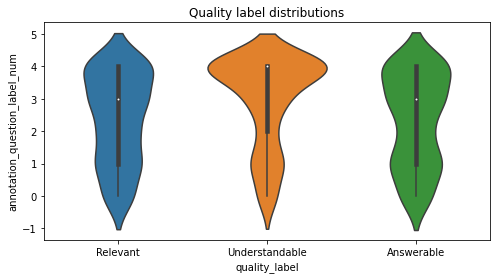

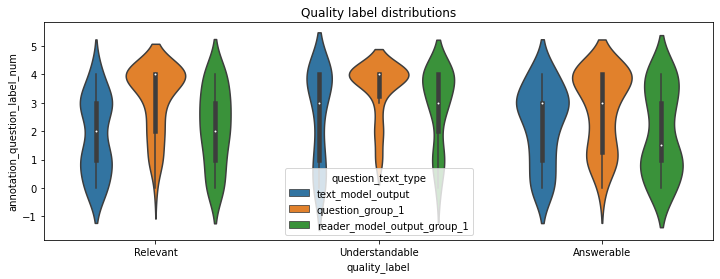

**** testing score = Answerable ****
question type 1 = text_model_output mean=2.260; question type 2 = question_group_1 mean=2.780
question type 1 = text_model_output mean=2.260; question type 2 = reader_model_output_group_1 mean=1.960
question type 1 = question_group_1 mean=2.780; question type 2 = reader_model_output_group_1 mean=1.960
median diff = 1.500 (test stat = 356.5, p = 1.648E-02)
**** testing score = Relevant ****
question type 1 = text_model_output mean=1.840; question type 2 = question_group_1 mean=3.140
median diff = -2.000 (test stat = 40.0, p = 1.711E-06)
question type 1 = text_model_output mean=1.840; question type 2 = reader_model_output_group_1 mean=2.160
question type 1 = question_group_1 mean=3.140; question type 2 = reader_model_output_group_1 mean=2.160
median diff = 2.000 (test stat = 110.5, p = 2.236E-04)
**** testing score = Understandable ****
question type 1 = text_model_output mean=2.540; question type 2 = question_group_1 mean=3.480
median diff = -1.000 (

In [23]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# overall distributions
plt.figure(figsize=(8, 4))
sns.violinplot(data=quality_annotated_data, x='quality_label', y='annotation_question_label_num')
plt.title('Quality label distributions')
plt.show()
# distributions by text type
plt.figure(figsize=(12, 4))
sns.violinplot(data=quality_annotated_data, x='quality_label', y='annotation_question_label_num', hue='question_text_type')
plt.title('Quality label distributions')
plt.show()
## TODO: significance by text type
from scipy.stats import wilcoxon, ttest_rel
question_text_types = quality_annotated_data.loc[:, 'question_text_type'].unique()
p_val_cutoff = 0.05
for score_i, data_i in quality_annotated_data.groupby('quality_label'):
    print(f'**** testing score = {score_i} ****')
    for j, question_text_type_j in enumerate(question_text_types):
        data_j = data_i[data_i.loc[:, 'question_text_type']==question_text_type_j].sort_values(['post_id', 'question_id_1', 'question_id_2'])
        scores_j = data_j[data_j.loc[:, 'quality_label']==score_i].loc[:, 'annotation_question_label_num']
        for question_text_type_k in question_text_types[(j+1):]:
            data_k = data_i[data_i.loc[:, 'question_text_type']==question_text_type_k].sort_values(['post_id', 'question_id_1', 'question_id_2'])
            scores_k = data_k[data_k.loc[:, 'quality_label']==score_i].loc[:, 'annotation_question_label_num']
            median_diff_j_k = scores_j.median() - scores_k.median()
            test_stat, p_val = wilcoxon(scores_j, scores_k)
            print(f'question type 1 = {question_text_type_j} mean={"{:.3f}".format(scores_j.mean())}; question type 2 = {question_text_type_k} mean={"{:.3f}".format(scores_k.mean())}')
            if(p_val < p_val_cutoff):
                print(f'median diff = {"{:.3f}".format(median_diff_j_k)} (test stat = {"{:.1f}".format(test_stat)}, p = {"{:.3E}".format(p_val)})')

- `Relevant`: human > reader-model ~ text-model (mean(reader-model) > mean(text-model))
- `Understandable`: human > reader-model ~ text-model (mean(reader-model) > mean(text-model))
- `Answerable`: human > text-model > reader-model (mean(text-model) > mean(reader-model))

How often did annotators guess the reader group correctly?

ResponseId
R_2DSkWaQ4e9WgAGA    0.5
R_2cj4KxI4AwETFLe    0.6
R_3EYn1o9YqUuVIwm    0.6
R_3oL3epAPgCpZ3Pv    0.7
R_yrpPCUi5DTJyLLP    0.6
dtype: float64


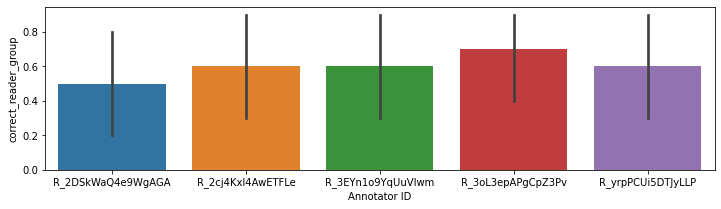

In [25]:
annotator_reader_group_guess_correct_pct = reader_group_annotated_data.groupby('ResponseId').apply(lambda x: x.loc[:, 'correct_reader_group'].mean())
print(annotator_reader_group_guess_correct_pct)
plt.figure(figsize=(12,3))
sns.barplot(data=reader_group_annotated_data, x='ResponseId', y='correct_reader_group')
plt.xlabel('Annotator ID')
plt.show()

Annotators guessed the correct reader group category slightly better than 50% of the time.